In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Carregando o dataset (ajuste o caminho do arquivo CSV conforme necessário)
df = pd.read_csv('base_unificada_ate_2015.csv')

# Lista de países únicos no dataset
paises = df['Local'].unique()

# Número de passos de tempo para olhar para trás
n_steps = 5

# Armazenar previsões e acurácia por país
previsoes_paises = {}
mse_paises = {}

# Criação de uma lista para armazenar os dados de previsão
dados_previsao = []

In [8]:
# Função para criar os conjuntos de dados de treinamento e teste
def create_dataset(features, target, n_steps):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i + n_steps])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

c:\Users\Fernando\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
País: Albania - Mean Squared Error: 1173708698.4557292
Limiar Epidêmico para Albania: 28370 casos por 100.000 habitantes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Ano: 2016 - Previsão: 686568.1875
Ano: 2017 - Previsão: 675874.75
Ano: 2018 - Previsão: 666896.375
Ano: 2019 - Previsão: 659316.0
Ano: 2020 - Previsão: 654032.6875
Ano: 2016 - Previsão de Incidência: 23459 - Status: Não em Epidemia
Ano: 2017 - Previsão de Incidência: 23146 - Status: Não em Epidemia
Ano: 2018 - Previsão de Incidência: 22847 - Status: Não em Epidemia
Ano: 2019 - Previsão de Incidência: 22573 - Status: Não em Epidemia
Ano: 2020 - Previsão de Incidência: 22373 - Status: Não em Epidemia


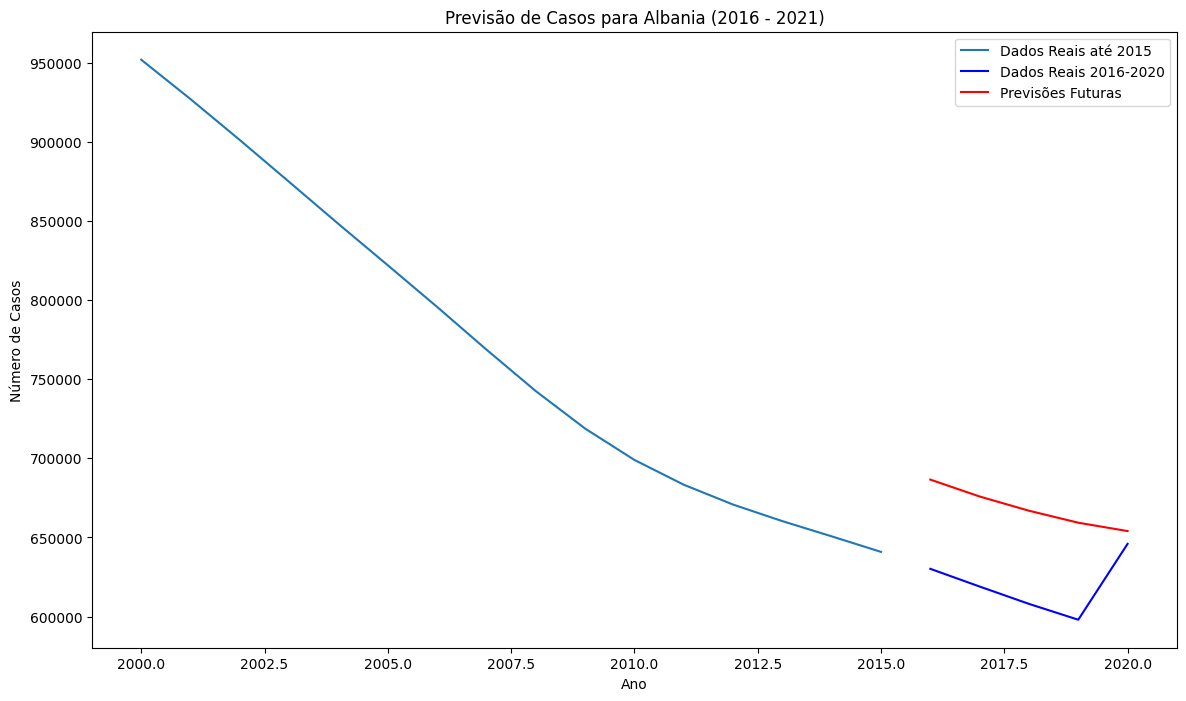

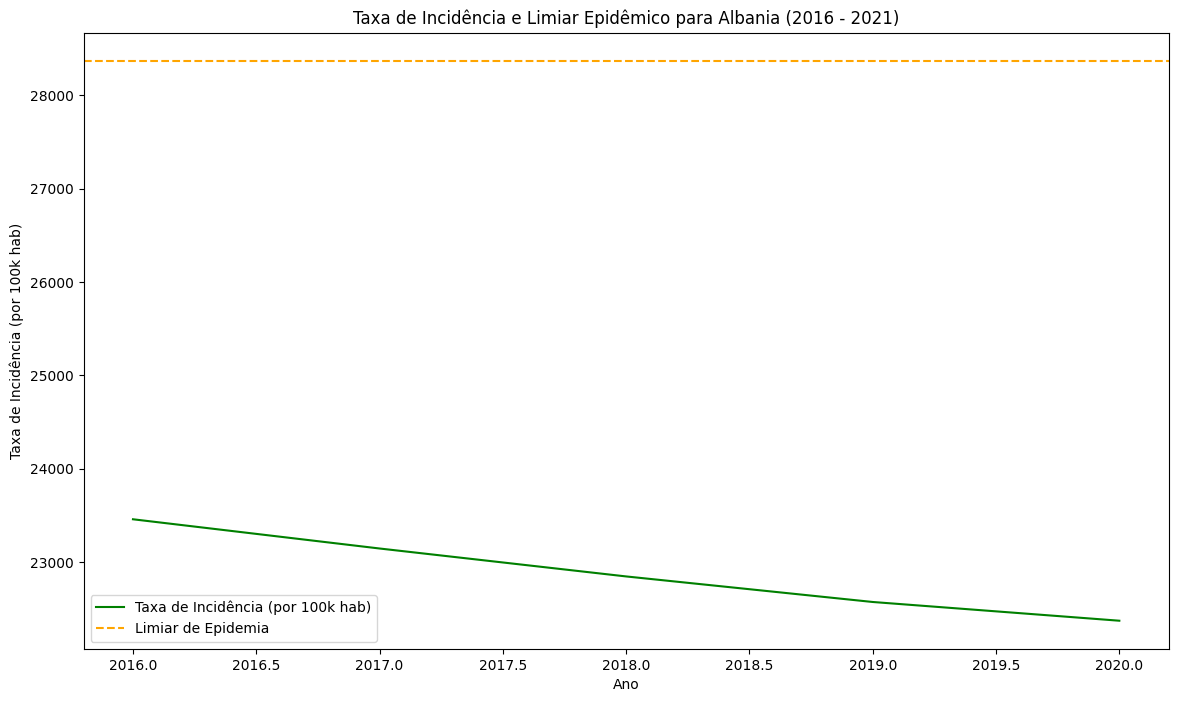

c:\Users\Fernando\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
País: Algeria - Mean Squared Error: 844196788.5
Limiar Epidêmico para Algeria: 17062 casos por 100.000 habitantes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ano: 2016 - Previsão: 5991675.0
Ano: 2017 - Previsão: 5982151.5
Ano: 2018 - Previsão: 5975654.5
Ano: 2019 - Previsão: 5970544.5
Ano: 2020 - Previsão: 5966522.5
Ano: 2016 - Previsão de Incidência: 16273 - Status: Não em Epidemia
Ano: 2017 - Previsão de Incidência: 15924 - Status: Não em Epidemia
Ano: 2018 - Previsão de Incidência: 15587 - Status: Não em Epidemia
Ano: 2019 - Previsão de Incidência: 15265 - Status: Não em Epidemia
Ano: 2020 - Previsão de Incidência: 14964 - Status: Não em Epidemia


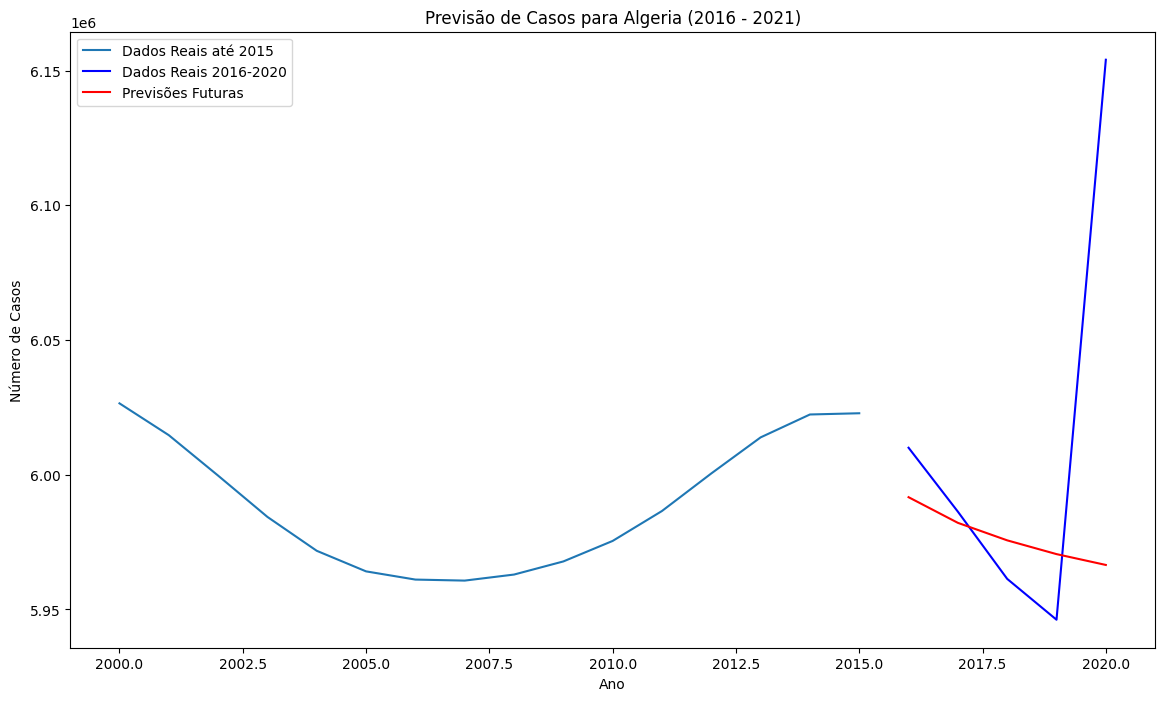

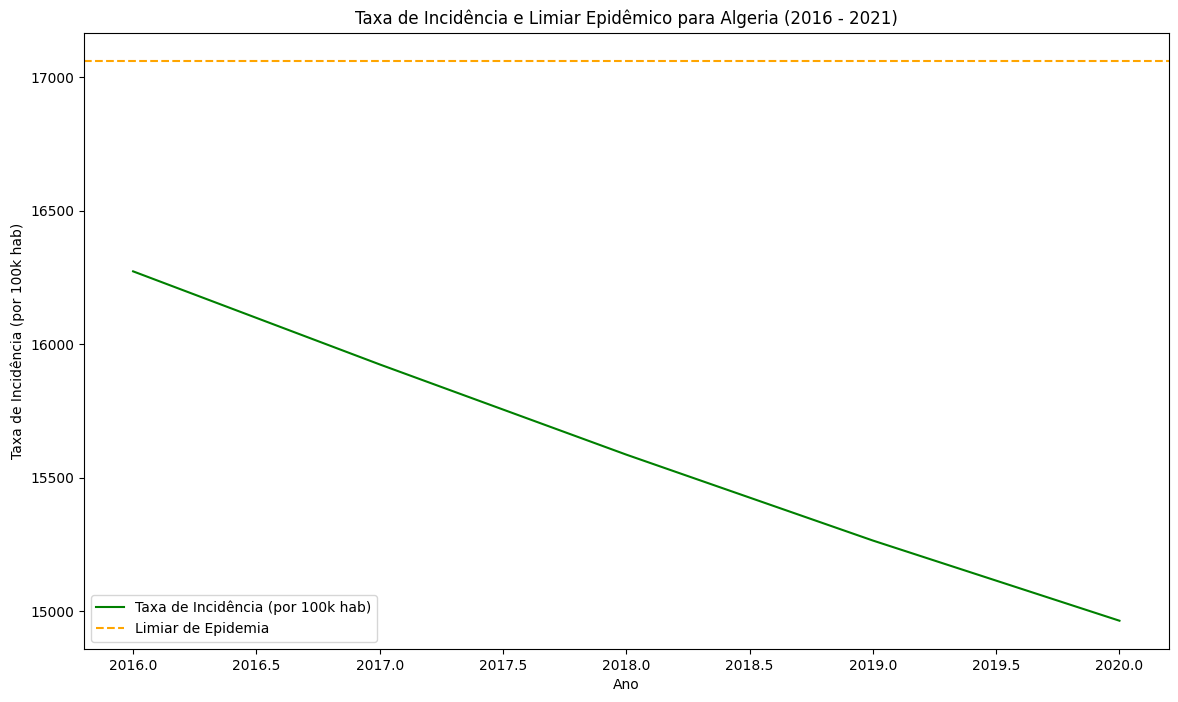

c:\Users\Fernando\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
df_reais = pd.read_csv('base_unificada_2016_2020.csv')

for pais in paises:
    # Filtrar os dados para o país
    df_pais = df[df['Local'] == pais]
    
    # Selecionar todas as colunas relevantes (exceto 'Local' e 'Ano') como features
    features = df_pais[['BCG', 'Hib3', 'DTP3', 'Saneamento Seguro (%)', 
                        'Numero Total de Imigrantes', 'Gini (Indice de Desigualdade no Pais)', 
                        'Populacao', 'Taxa de Extrema Pobreza (%)', 'Numero de Usuario de Internet']].values

    # Selecionar a coluna de interesse para prever (número de infecções respiratórias e tuberculose)
    target = df_pais['Numero de Casos de Infeccoes Respiratorios e Tuberculose'].values.reshape(-1, 1)

    # Normalizando os dados (tanto as features quanto o target)
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(features)

    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_target = scaler_target.fit_transform(target)

    # Criando os conjuntos de dados
    X, y = create_dataset(scaled_features, scaled_target, n_steps)

    # Dividindo em conjunto de treinamento e teste (80% para treino, 20% para teste)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape para o LSTM [amostras, passos de tempo, características]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Modelo LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=400, verbose=0, validation_split=0.1, callbacks=[early_stopping])

    # Fazendo previsões
    y_pred = model.predict(X_test)
    y_pred = scaler_target.inverse_transform(y_pred)
    y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Calculando o erro para o país
    mse = mean_squared_error(y_test, y_pred)
    mse_paises[pais] = mse
    print(f'País: {pais} - Mean Squared Error: {mse}')

    # Cálculo do limiar epidêmico com dados dos últimos 15 anos
    dados_historicos = df_pais['Numero de Casos de Infeccoes Respiratorios e Tuberculose'].tail(15).values
    populacao_historica = df_pais['Populacao'].tail(15).values  # Obter a população correspondente

    # Cálculo da média e desvio padrão
    media_casos = np.mean(dados_historicos)
    desvio_padrao_casos = np.std(dados_historicos)

    # Calcular a média e o desvio padrão da taxa de incidência
    media_incidencia = (media_casos / np.mean(populacao_historica)) * 100000
    desvio_padrao_incidencia = (desvio_padrao_casos / np.mean(populacao_historica)) * 100000

    # Cálculo do limiar epidêmico
    k = 1
    limiar_epidemico = media_incidencia + (k * desvio_padrao_incidencia)

    print(f'Limiar Epidêmico para {pais}: {limiar_epidemico:.0f} casos por 100.000 habitantes')

    # Previsão futura
    last_sequence = scaled_features[-n_steps:]
    predictions = []
    n_features = 9

    for _ in range(5):  # Prever os próximos 5 anos
        last_sequence = last_sequence.reshape((1, n_steps, X_train.shape[2]))
        next_value = model.predict(last_sequence)
        predictions.append(next_value[0, 0])
        next_value_expanded = np.repeat(np.expand_dims(next_value, axis=1), n_features, axis=2)
        last_sequence = np.concatenate((last_sequence[:, 1:, :], next_value_expanded), axis=1)

    # Convertendo as previsões para o formato original
    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    previsoes_paises[pais] = predictions.flatten()

    populacoes = df_pais['Populacao'].values[-len(predictions):]
    taxas_incidencia = (predictions.flatten() / populacoes) * 100000

    inicio_previsao = 2016
    fim_previsao = 2021

    future_years = list(range(inicio_previsao, fim_previsao))
    for year, pred in zip(future_years, previsoes_paises[pais]):
        print(f'Ano: {year} - Previsão: {pred}')

    # Verificando se o país estará em epidemia
    em_epidemia = taxas_incidencia > limiar_epidemico
    for i, em_epidemia_ano in enumerate(em_epidemia):
        status_epidemia = "Epidemia" if em_epidemia_ano else "Não em Epidemia"
        print(f'Ano: {inicio_previsao + i} - Previsão de Incidência: {taxas_incidencia[i]:.0f} - Status: {status_epidemia}')

    # Salve os dados de previsão em uma lista
    for year, pred, taxa in zip(future_years, previsoes_paises[pais], taxas_incidencia):
        dados_previsao.append({
            'País': pais,
            'Ano': year,
            'Previsão de Casos': pred,
            'Taxa de Incidência (por 100k hab)': taxa,
            'Status de Epidemia': "Epidemia" if taxa > limiar_epidemico else "Não em Epidemia"
        })

    # Extraindo os dados reais para o país
    dados_reais_pais = df_reais[df_reais['Local'] == pais]

    # Plotando as previsões e a taxa de incidência
    plt.figure(figsize=(14, 8))
    
    # Plotando dados reais até 2015
    plt.plot(df_pais['Ano'], df_pais['Numero de Casos de Infeccoes Respiratorios e Tuberculose'], label='Dados Reais até 2015')
    
    # Plotando dados reais de 2016 a 2020
    plt.plot(dados_reais_pais['Ano'], dados_reais_pais['Numero de Casos de Infeccoes Respiratorios e Tuberculose'], label='Dados Reais 2016-2020', color='blue')
    
    # Plotando previsões futuras
    plt.plot(future_years, previsoes_paises[pais], label='Previsões Futuras', color='red')
    plt.xlabel('Ano')
    plt.ylabel('Número de Casos')
    plt.title(f'Previsão de Casos para {pais} ({inicio_previsao} - {fim_previsao})')
    plt.legend()
    plt.show()  

    # Gráfico separado para Taxa de Incidência e Limiar Epidêmico
    plt.figure(figsize=(14, 8))
    plt.plot(future_years, taxas_incidencia, label='Taxa de Incidência (por 100k hab)', color='green')
    plt.axhline(y=limiar_epidemico, color='orange', linestyle='--', label='Limiar de Epidemia')
    plt.xlabel('Ano')
    plt.ylabel('Taxa de Incidência (por 100k hab)')
    plt.title(f'Taxa de Incidência e Limiar Epidêmico para {pais} ({inicio_previsao} - {fim_previsao})')
    plt.legend()
    plt.show()

# Criação do DataFrame a partir da lista de previsões
df_previsao = pd.DataFrame(dados_previsao)

# Arredondar os valores nas colunas 'Previsão de Casos' e 'Taxa de Incidência (por 100k hab)'
df_previsao['Previsão de Casos'] = df_previsao['Previsão de Casos'].round(0).astype(int)
df_previsao['Taxa de Incidência (por 100k hab)'] = df_previsao['Taxa de Incidência (por 100k hab)'].round(0).astype(int)

# Salvando em um novo arquivo CSV
df_previsao.to_csv('previsao_casos_e_taxa_incidencia.csv', index=False)

print("Dados de previsão salvos em 'previsao_casos_e_taxa_incidencia.csv'")
